In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit


def make_grid(N, L, center, **kwargs):
    # Границы сетки
    x = np.linspace(-L[0]/2 - center[0], L[0]/2 - center[0], N[0] + 1)
    y = np.linspace(-L[1]/2 - center[1], L[1]/2 - center[1], N[1] + 1)
    z = np.linspace(-L[2]/2 - center[2], L[2]/2 - center[2], N[2] + 1)
    
    # Объем ячейки
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    h_z = z[1] - z[0]
    volume = h_x * h_y * h_z
    
    # Середины - точки коллокации
    x = (x[1:] + x[:-1])/2
    y = (y[1:] + y[:-1])/2
    z = (z[1:] + z[:-1])/2
    
    # Сетка - трехмерный тензор
    grid = np.array(np.meshgrid(x, y, z, indexing='ij')).T.reshape(-1, 3)
    
    return grid, volume


def step_dielectric_3d(grid,
                       eps_real,
                       eps_imag,
                       x1_bounds,
                       x2_bounds,
                       x3_bounds):
    """
    grid - Тензор (n_1, n_2, n_3, 3) для каждой точки пространства
    eps_real
    """
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if x1_bounds is None:
        x1_bounds = [-1.0, 0.5]
    if x2_bounds is None:
        x2_bounds = [-1.0, 1.0]
    if x3_bounds is None:
        x3_bounds = [-1.0, 1.0]

    eps = np.zeros((grid.shape[0])) + 0.0j
    indexes = ((grid[:, 0] >= x1_bounds[0]) * (grid[:, 0] <= x1_bounds[1]) *
               (grid[:, 1] >= x2_bounds[0]) * (grid[:, 1] <= x2_bounds[1]) *
               (grid[:, 2] >= x3_bounds[0]) * (grid[:, 2] <= x3_bounds[1]))
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def ellipsis_dielectric_3d(grid,
                           eps_real,
                           eps_imag,
                           center,
                           radius):
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if center is None:
        center = [0.0, 0.0, 0.0]
    if radius is None:
        radius = [1.0, 1.0, 1.0]
    eps = np.zeros((grid.shape[0])) + 0j
    indexes = (
        ((grid[:, 0] - center[0]) ** 2) / (radius[0] ** 2) +
        ((grid[:, 1] - center[1]) ** 2) / (radius[1] ** 2) +
        ((grid[:, 2] - center[2]) ** 2) / (radius[2] ** 2)
    ) <= 1
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def apply_dielectric_3d(grid,
                        eps_vec=None, **kwargs):
    if eps_vec is None:
        eps_vec = [
            {
                "type": "step",
                "eps_real": 1.0,
                "eps_imag": 0.0,
                "x1_bounds": [-1.0, 0.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": 1.0,
                "eps_imag": 0.0,
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
        ]

    eps = np.zeros((grid.shape[0])) + 0j
    indexes = np.zeros(grid.shape[0], dtype=bool)
    for num, element in enumerate(eps_vec):
        if element.get("type") == "step":
            eps_d, indexes_d = step_dielectric_3d(grid=grid,
                                                  eps_real=element.get('eps_real'),
                                                  eps_imag=element.get('eps_imag'),
                                                  x1_bounds=element.get('x1_bounds'),
                                                  x2_bounds=element.get('x2_bounds'),
                                                  x3_bounds=element.get('x3_bounds'))
        elif element.get("type") == "ellipsis":
            eps_d, indexes_d = ellipsis_dielectric_3d(grid=grid,
                                                      eps_real=element.get('eps_real'),
                                                      eps_imag=element.get('eps_imag'),
                                                      center=element.get('center'),
                                                      radius=element.get('radius'))
        else:
            continue
        indexes += indexes_d
        eps += eps_d
    return eps, indexes


def kernel(x, k=1, **kwargs):
    return np.exp(1j * k * x)/(4 * np.pi * x)


def wave(x, k=1, orient=[1.0, 1.0, 1.0], sign=1, amplitude=1.0, **kwargs):
    orient = np.array(orient) / np.linalg.norm(np.array(orient), 2)
    return amplitude * np.exp(sign * 1j * k * (x.dot(orient)))


def prep_fftbbtensor(col_arr,
                     row_arr,
                     n, m, k):
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    col_arr = col_arr.reshape((n, m, k))
    row_arr = row_arr.reshape((n, m, k))
    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[(n + 1):(2 * n), (m + 1):(2 * m), :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, (m + 1):(2 * m), (k + 1):(2 * k)] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[(n + 1):(2 * n), :m, (k + 1):(2 * k)] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[(n + 1):(2 * n), (m + 1):(2 * m), (k + 1):(2 * k)] = col_arr[n:0:-1, m:0:-1, k:0:-1]
    circulant_tensor = np.fft.fftn(circulant_tensor)
    return circulant_tensor


def prep_fbbtmv(prep_fft_arr,
                vec_arr,
                n, m, k):
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]
    prep_fft_arr = np.fft.ifftn(prep_fft_arr * np.fft.fftn(x_arr))
    return prep_fft_arr[:n, :m, :k]


def operator(prep_array, vector_array, nu, k, n_1, n_2, n_3):
    result = np.zeros((n_3 * n_2 * n_1, )) + 0.0j
    vec_array = nu * vector_array
    result = prep_fbbtmv(prep_array,
                         vec_array.reshape((n_3, n_2, n_1)),
                         n_3, n_2, n_1).reshape(-1,)
    result = vector_array - k**2 * result
    return result


def conj_operator(conj_prep_array, vector_array, nu, k, n_1, n_2, n_3):
    result = np.zeros((n_3 * n_2 * n_1, )) + 0.0j
    result = np.conj(nu) * prep_fbbtmv(conj_prep_array, 
                                       vector_array.reshape((n_3, n_2, n_1)), 
                                       n_3, n_2, n_1).reshape(-1,)
    result = vector_array - k**2 * result
    return result


# Стабилизированный метод бисопряженных градиентов
def bicg_norm(x):
    return np.sqrt(np.sum(x * np.conj(x)).real)


def bicg_ldot(x, y):
    return np.sum(np.conj(x) * y)


def bicg_rdot(x, y):
    return np.sum(x * y)


def bicgstab(prep_fourier_oper, vector_f, vector_nu,  k=None,
             vector_u0=None, n_1=20, n_2=20, n_3=20, tol=1e-8, max_iter=1000):
    if vector_u0 is None:
        vector_u0 = np.zeros(vector_f.shape) + 0.0j
    if max_iter is None:
        max_iter = 100
    if k is None:
        k = 1.0
    
    norm_f = bicg_norm(vector_f)
    
    # Логи итераций
    iters_list = []
    eps_list = []
    resid_list = []
    
    # Вычислим начальную невязку
    r = vector_f - operator(prep_fourier_oper, vector_u0, vector_nu, k, n_1, n_2, n_3)
    resid_list.append(r)
    iters_list.append(1)
    eps_list.append(0)
    
    # Параметры алгоритма
    # Копия начальной невязки для BICG (r tilde)
    r_tilde = r.copy()
    rho_old = 1.0 + 0.0j
    alpha = 1.0 + 0.0j
    omega = 1.0 + 0.0j

    # Векторы p, v обнуляем
    v = np.zeros(vector_f.shape) + 0.0j
    p = np.zeros(vector_f.shape) + 0.0j
    
    # Проверяем, не является ли начальное приближение уже решением
    norm_r = bicg_norm(r)
    if norm_r < tol:
        return vector_u0, iters_list, eps_list, resid_list

    for it in range(1, max_iter+1):
        # Вычисляем скалярное произведение (rho_new = <r_tilde, r>)
        # np.vdot учитывает комплексное сопряжение первого аргумента
        rho_new = bicg_ldot(r_tilde, r)
        
        # Если rho_new близко к 0, алгоритм может потерять устойчивость
        if abs(rho_new) < 1e-15:
            # Полагаем, что метод не может продолжаться
            return vector_u0, iters_list, eps_list, resid_list
        
        beta = (rho_new / rho_old) * (alpha / omega)
        rho_old = rho_new * 1.0
    
        # Обновляем направление p
        p = r + beta * (p - omega * v)
        
        # Считаем v = A * p
        v = operator(prep_fourier_oper, p, vector_nu, k, n_1, n_2, n_3)
        
        # alpha = rho_new / <r_tilde, v>
        denom = bicg_ldot(r_tilde, v)
        if abs(denom) < 1e-15:
            print('Метод вырождается')
            return vector_u0, iters_list, eps_list, resid_list
        alpha = rho_new / denom
        
        # Новая невязка s
        s = r - alpha * v
        
        # Проверяем остаток (s)
        norm_s = bicg_norm(s)
        if norm_s < tol:
            print('достичь нужной точности смогли быстрее')
            x = vector_u0 + alpha * p
            return x, iters_list, eps_list, resid_list  
        
        # t = A*s
        t = operator(prep_fourier_oper, s, vector_nu, k, n_1, n_2, n_3)
        
        # omega = <t, s> / <t, t>
        denom_ts = bicg_rdot(t, t)
        if abs(denom_ts) < 1e-15:
            print('Метод вырождается')
            return vector_u0, iters_list, eps_list, resid_list
        omega = bicg_rdot(t, s) / denom_ts
        
        # Обновляем решение
        x = vector_u0 + alpha * p + omega * s
        
        # Обновляем невязку
        r = s - omega * t
        
        # Проверяем условие останова по невязке
        norm_r = bicg_norm(r)
        eps = bicg_norm(x - vector_u0) / norm_f
        eps_list.append(eps)
        resid_list.append(norm_r)
        iters_list.append(iters_list[-1] + 2)
        print(f'Итерация №{it}: Умножений М-В L = {3 + 2 * it}, Умножений В-В V = {2 + 2 * it}, Критерий останова eps = {eps}')
        if eps < tol:
            return x, iters_list, eps_list, resid_list  # решение найдено с нужной точностью
        
        # Если omega близко к 0, то есть риск деления на ноль на следующем шаге
        if abs(omega) < 1e-15:
            # Метод зашёл в тупик
            return x, iters_list, eps_list, resid_list
        
        vector_u0 = x * 1.0
    
    # Если цикл закончился без достижения точности, возвращаем x и число итераций
    return x, iters_list, eps_list, resid_list


# Двухшаговый метод градиентного спуска
def complex_norm(a):
    return np.sum(a * np.conj(a)).real


def TwoStep(prep_fourier_oper, prep_conj_oper, vector_f, vector_nu, k, 
            z_0=None, n_1=20, n_2=20, n_3=20, rtol=10e-8, max_iter=None):
    
    if max_iter is None:
        max_iter=100
    if z_0 is None:
        z_0 = np.zeros(vector_f.shape) + 0.0j
    
    # Логи итераций
    iters_list = []
    eps_list = []
    resid_list = []
    
    # Норма вектора свободных коэффициентов
    f_norm = np.sqrt(complex_norm(vector_f))
    
    # Итерационный процесс
    l_0 = operator(prep_fourier_oper, z_0, vector_nu, k, n_1, n_2, n_3)
    r_0 = l_0 - vector_f
    l_1 = conj_operator(prep_conj_oper, r_0, vector_nu, k, n_1, n_2, n_3)
    l_2 = operator(prep_fourier_oper, l_1, vector_nu, k, n_1, n_2, n_3)
    z_1 = z_0 - complex_norm(l_1) / complex_norm(l_2) * l_1
    
    # Расчет критерия останова
    eps = np.sqrt(complex_norm(z_1 - z_0)) / f_norm
    
    # Пополнение списков для логов итераций
    iters_list.append(3)
    eps_list.append(eps)
    resid_list.append(complex_norm(r_0))
    print(f'Итерация №1: Умножений М-В L = {iters_list[-1]}, Умножений В-В V = {4}, Критерий останова eps = {eps_list[-1]}')
    if (eps < rtol):
        return z_1, iters_list, eps_list, resid_list 
    
    # Цикл, если 
    for it in range(2, max_iter+1):
        l_0 = operator(prep_fourier_oper, z_1, vector_nu, k, n_1, n_2, n_3)
        r_k = l_0 - vector_f
        l_1 = conj_operator(prep_conj_oper, r_k, vector_nu, k, n_1, n_2, n_3)
        l_2 = operator(prep_fourier_oper, l_1, vector_nu, k, n_1, n_2, n_3)
        
        delta_rk = r_k - r_0
        a_0 = complex_norm(delta_rk)
        a_1 = complex_norm(l_1)
        a_2 = complex_norm(l_2)
        
        det = (a_0 * a_2 - a_1 * a_1)
        t_k = -(a_1 * a_1) / det
        h_k = (a_0 * a_1) / det
        
        z_k = z_1 - t_k * (z_1 - z_0) - h_k * l_1
        
        eps = np.sqrt(complex_norm(z_k - z_1)) / f_norm 
        
        iters_list.append(iters_list[-1] + 3)
        eps_list.append(eps)
        resid_list.append(complex_norm(r_k))

        print(f'Итерация №{it}: Умножений М-В L = {iters_list[-1]}, Умножений В-В V = {it*4}, Критерий останова eps = {eps_list[-1]}')
        if (eps < rtol):
            break
        
        r_0 = np.copy(r_k)
        z_0 = np.copy(z_1)
        z_1 = np.copy(z_k)
    return z_k, iters_list, eps_list, resid_list

# Постановка задачи и решение

In [14]:
problem_config = {
    'N': [300, 300, 300],
    'L': [3.0, 3.0, 3.0],
    'center': [0.0, 0.0, 0.0],
    'k': 20.0,
    'orient': [1.0, 1.0, 1.0],
    'amplitude': 1.0,
    'sign': 1.0,
    'eps_vec': [
        {
            "type": "step",
            "eps_real": 2.0,
            "eps_imag": 0.0,
            "x1_bounds": [-2.0, 2.0],
            "x2_bounds": [-2.0, 2.0],
            "x3_bounds": [-2.0, 2.0]
        },
        {
            "type": "step",
            "eps_real": 0.0,
            "eps_imag": 0.0,
            "x1_bounds": [-2.0, 0.0],
            "x2_bounds": [-2.0, 2.0],
            "x3_bounds": [-2.0, 2.0]
        },
        {
            "type": "ellipsis",
            "eps_real": 2.0,
            "eps_imag": 3.0,
            "center": [0.0, 0.0, 0.0],
            "radius": [1.0, 1.0, 1.0]
        }
    ]
}

n_1 = problem_config.get('N')[0]
n_2 = problem_config.get('N')[1]
n_3 = problem_config.get('N')[2]

to_reshape = [n_3, n_2, n_1]

k_wave = problem_config.get('k')

# Трехмерная сетка
grid, volume = make_grid(**problem_config)

# Индекс рефракции среды, определенный в точках сетки
eta, indexes = apply_dielectric_3d(grid, **problem_config)

# Внешняя волна, определенная в точках сетки
f_wave = wave(grid, **problem_config)

# Определение массива дисркетизированного ядра оператора
dists = np.sqrt(np.sum((grid[0] - grid[:])**2, axis = 1))
dists[0] = 10e-8

# Заполнение первой строки матрицы 
G_array = kernel(dists, **problem_config) * volume
G_array[0] = 0

# Коэффициенты B в Фурье-образе
prep_coeffs = prep_fftbbtensor(G_array.reshape(to_reshape), 
                               G_array.reshape(to_reshape),
                               n_3, n_2, n_1)

# Сопряженные коэффициенты в Фурье-образе
prep_conj_coeffs = prep_fftbbtensor(np.conj(G_array).reshape(to_reshape), 
                                    np.conj(G_array).reshape(to_reshape),
                                    n_3, n_2, n_1)


# Умножение внешней волны на ядро оператора
u0_array = -1.0 * prep_fbbtmv(prep_coeffs, f_wave.reshape(to_reshape), n_3, n_2, n_1).reshape(-1, )

In [15]:
# Решение задачи с помощью стабилизированного метода бисопряженных градиентов
start_time = timeit.default_timer()
result_BICGStab, iters_BICGStab, eps_BICGStab, resid_BICGStab = \
bicgstab(prep_coeffs, 
         u0_array, 
         (eta-1),
         k_wave,
         vector_u0=None, 
         n_1=n_1, n_2=n_2, n_3=n_3, 
         tol=1e-7, max_iter=150)
elapsed = timeit.default_timer() - start_time
print(elapsed)

Итерация №1: Умножений М-В L = 5, Умножений В-В V = 4, Критерий останова eps = 0.03444802329832681
Итерация №2: Умножений М-В L = 7, Умножений В-В V = 6, Критерий останова eps = 0.024483539606116975
Итерация №3: Умножений М-В L = 9, Умножений В-В V = 8, Критерий останова eps = 0.05495430295451509
Итерация №4: Умножений М-В L = 11, Умножений В-В V = 10, Критерий останова eps = 0.06673639226025138
Итерация №5: Умножений М-В L = 13, Умножений В-В V = 12, Критерий останова eps = 0.06519984069251117
Итерация №6: Умножений М-В L = 15, Умножений В-В V = 14, Критерий останова eps = 0.015094693709544228
Итерация №7: Умножений М-В L = 17, Умножений В-В V = 16, Критерий останова eps = 0.0824682590408609
Итерация №8: Умножений М-В L = 19, Умножений В-В V = 18, Критерий останова eps = 0.06601213225318733
Итерация №9: Умножений М-В L = 21, Умножений В-В V = 20, Критерий останова eps = 0.32918444865090674
Итерация №10: Умножений М-В L = 23, Умножений В-В V = 22, Критерий останова eps = 0.265598856151

Итерация №82: Умножений М-В L = 167, Умножений В-В V = 166, Критерий останова eps = 0.7957382034245545
Итерация №83: Умножений М-В L = 169, Умножений В-В V = 168, Критерий останова eps = 3.07510647460945
Итерация №84: Умножений М-В L = 171, Умножений В-В V = 170, Критерий останова eps = 0.3560833158467929
Итерация №85: Умножений М-В L = 173, Умножений В-В V = 172, Критерий останова eps = 4.7155572624500195
Итерация №86: Умножений М-В L = 175, Умножений В-В V = 174, Критерий останова eps = 3.218837344132352
Итерация №87: Умножений М-В L = 177, Умножений В-В V = 176, Критерий останова eps = 20.306339514294166
Итерация №88: Умножений М-В L = 179, Умножений В-В V = 178, Критерий останова eps = 14.652122988903834
Итерация №89: Умножений М-В L = 181, Умножений В-В V = 180, Критерий останова eps = 2.9083466234174087
Итерация №90: Умножений М-В L = 183, Умножений В-В V = 182, Критерий останова eps = 2.1726085984933983
Итерация №91: Умножений М-В L = 185, Умножений В-В V = 184, Критерий останов

In [16]:
# Решение задачи с помощью двухшагового метода градиентного спуска
start_time = timeit.default_timer()
result_TS, iters_TS, eps_TS, resid_TS = \
TwoStep(prep_fourier_oper=prep_coeffs, 
        prep_conj_oper=prep_conj_coeffs, 
        vector_f=u0_array, 
        vector_nu=eta-1, 
        k=k_wave, 
        z_0=None, 
        n_1=n_1, n_2=n_2, n_3=n_3, 
        rtol=10e-8, 
        max_iter=100)
elapsed = timeit.default_timer() - start_time
print(elapsed)

Итерация №1: Умножений М-В L = 3, Умножений В-В V = 4, Критерий останова eps = 0.010577287016374877
Итерация №2: Умножений М-В L = 6, Умножений В-В V = 8, Критерий останова eps = 0.005774915032388161
Итерация №3: Умножений М-В L = 9, Умножений В-В V = 12, Критерий останова eps = 0.008068473485843735
Итерация №4: Умножений М-В L = 12, Умножений В-В V = 16, Критерий останова eps = 0.008125223653158603
Итерация №5: Умножений М-В L = 15, Умножений В-В V = 20, Критерий останова eps = 0.007082349214222873
Итерация №6: Умножений М-В L = 18, Умножений В-В V = 24, Критерий останова eps = 0.005384121892398454
Итерация №7: Умножений М-В L = 21, Умножений В-В V = 28, Критерий останова eps = 0.004509459710379172
Итерация №8: Умножений М-В L = 24, Умножений В-В V = 32, Критерий останова eps = 0.0038413892007327366
Итерация №9: Умножений М-В L = 27, Умножений В-В V = 36, Критерий останова eps = 0.003052036520327042
Итерация №10: Умножений М-В L = 30, Умножений В-В V = 40, Критерий останова eps = 0.00

Итерация №79: Умножений М-В L = 237, Умножений В-В V = 316, Критерий останова eps = 0.00019441210058291055
Итерация №80: Умножений М-В L = 240, Умножений В-В V = 320, Критерий останова eps = 0.0002822950954742764
Итерация №81: Умножений М-В L = 243, Умножений В-В V = 324, Критерий останова eps = 0.00015899839471604843
Итерация №82: Умножений М-В L = 246, Умножений В-В V = 328, Критерий останова eps = 0.0003171034293645895
Итерация №83: Умножений М-В L = 249, Умножений В-В V = 332, Критерий останова eps = 0.00023089360996580437
Итерация №84: Умножений М-В L = 252, Умножений В-В V = 336, Критерий останова eps = 0.0002720655327456178
Итерация №85: Умножений М-В L = 255, Умножений В-В V = 340, Критерий останова eps = 0.0001832857571369732
Итерация №86: Умножений М-В L = 258, Умножений В-В V = 344, Критерий останова eps = 0.00012595686615463105
Итерация №87: Умножений М-В L = 261, Умножений В-В V = 348, Критерий останова eps = 0.00037532639720955457
Итерация №88: Умножений М-В L = 264, Умно

In [38]:
def plot_yx(array, grid, idx=None):
    if idx is None:
        idx = array.shape[2]//2
    plt.figure(figsize=(9, 8), dpi=256)
    plt.imshow(array[:, :, idx], cmap="binary")
    x_min = np.min(grid[0, 0, 0, 0])
    x_max = np.max(grid[0, 0, 0, 0])
    y_min = np.min(grid[0, 0, 0, 1])
    y_max = np.max(grid[0, 0, 0, 1])
    grid_x = np.linspace(x_min, x_max, 10)
    grid_y = np.linspace(y_min, y_max, 10)
    plt.colorbar()
    plt.ylabel(r"$x_1$", fontsize=16)
    plt.xlabel(r"$x_2$", fontsize=16)
    plt.show()

Text(0.5, 0, '$x_2$')

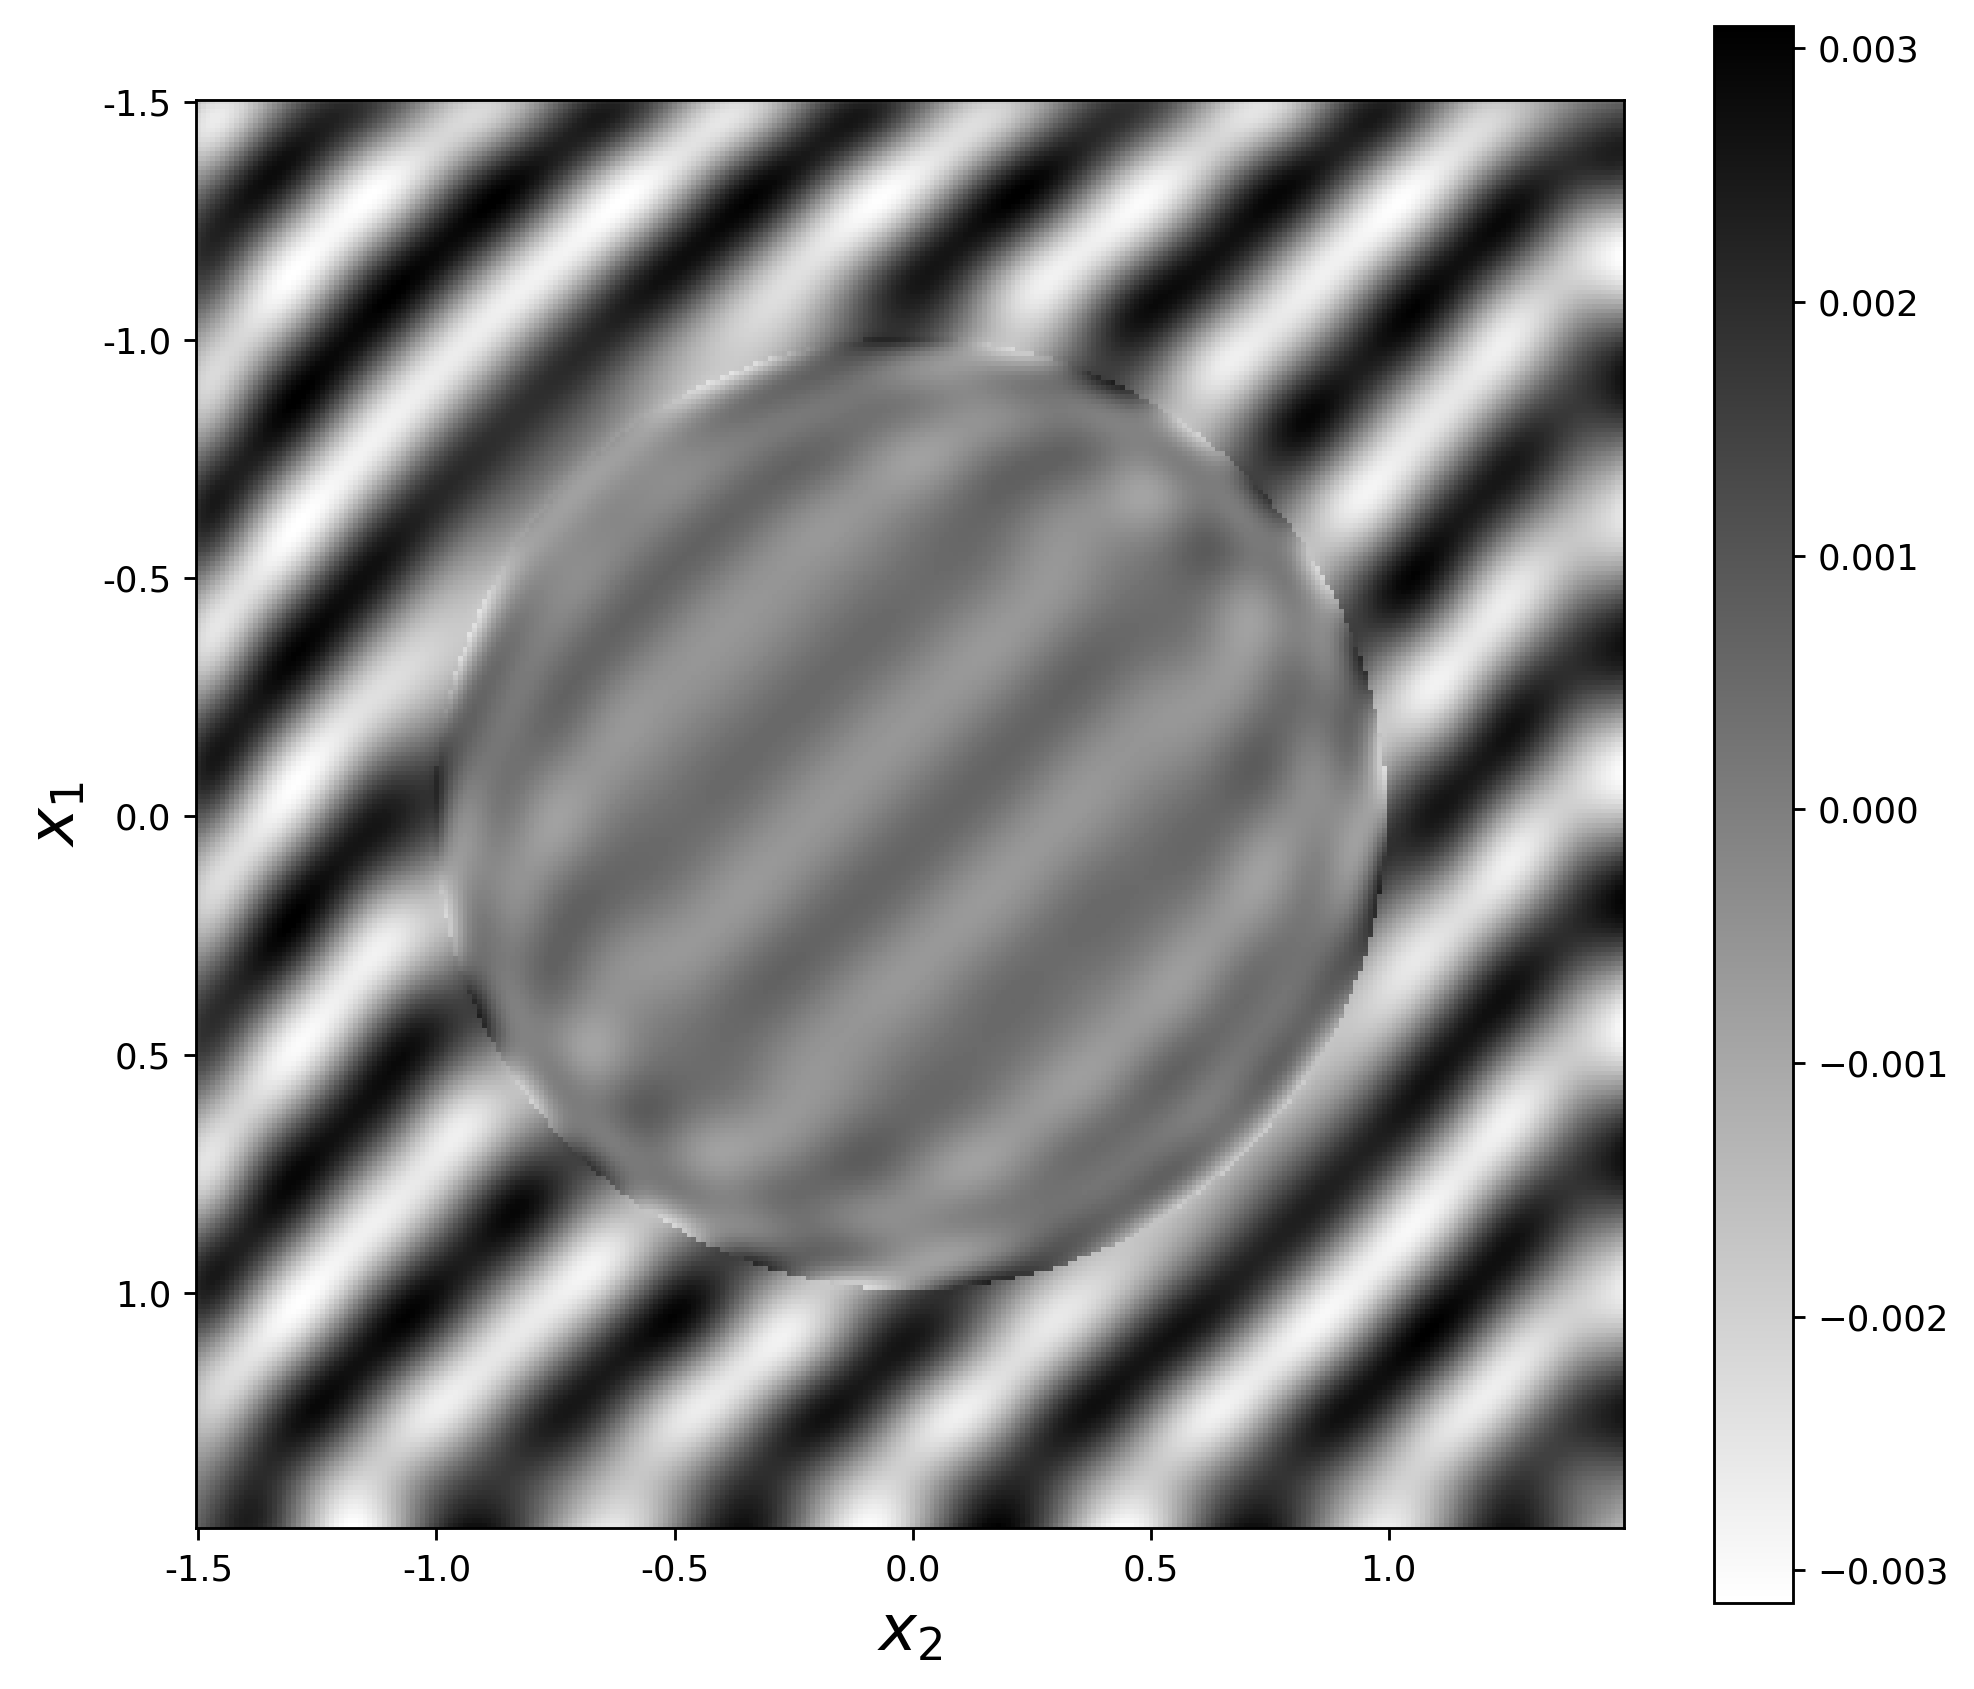

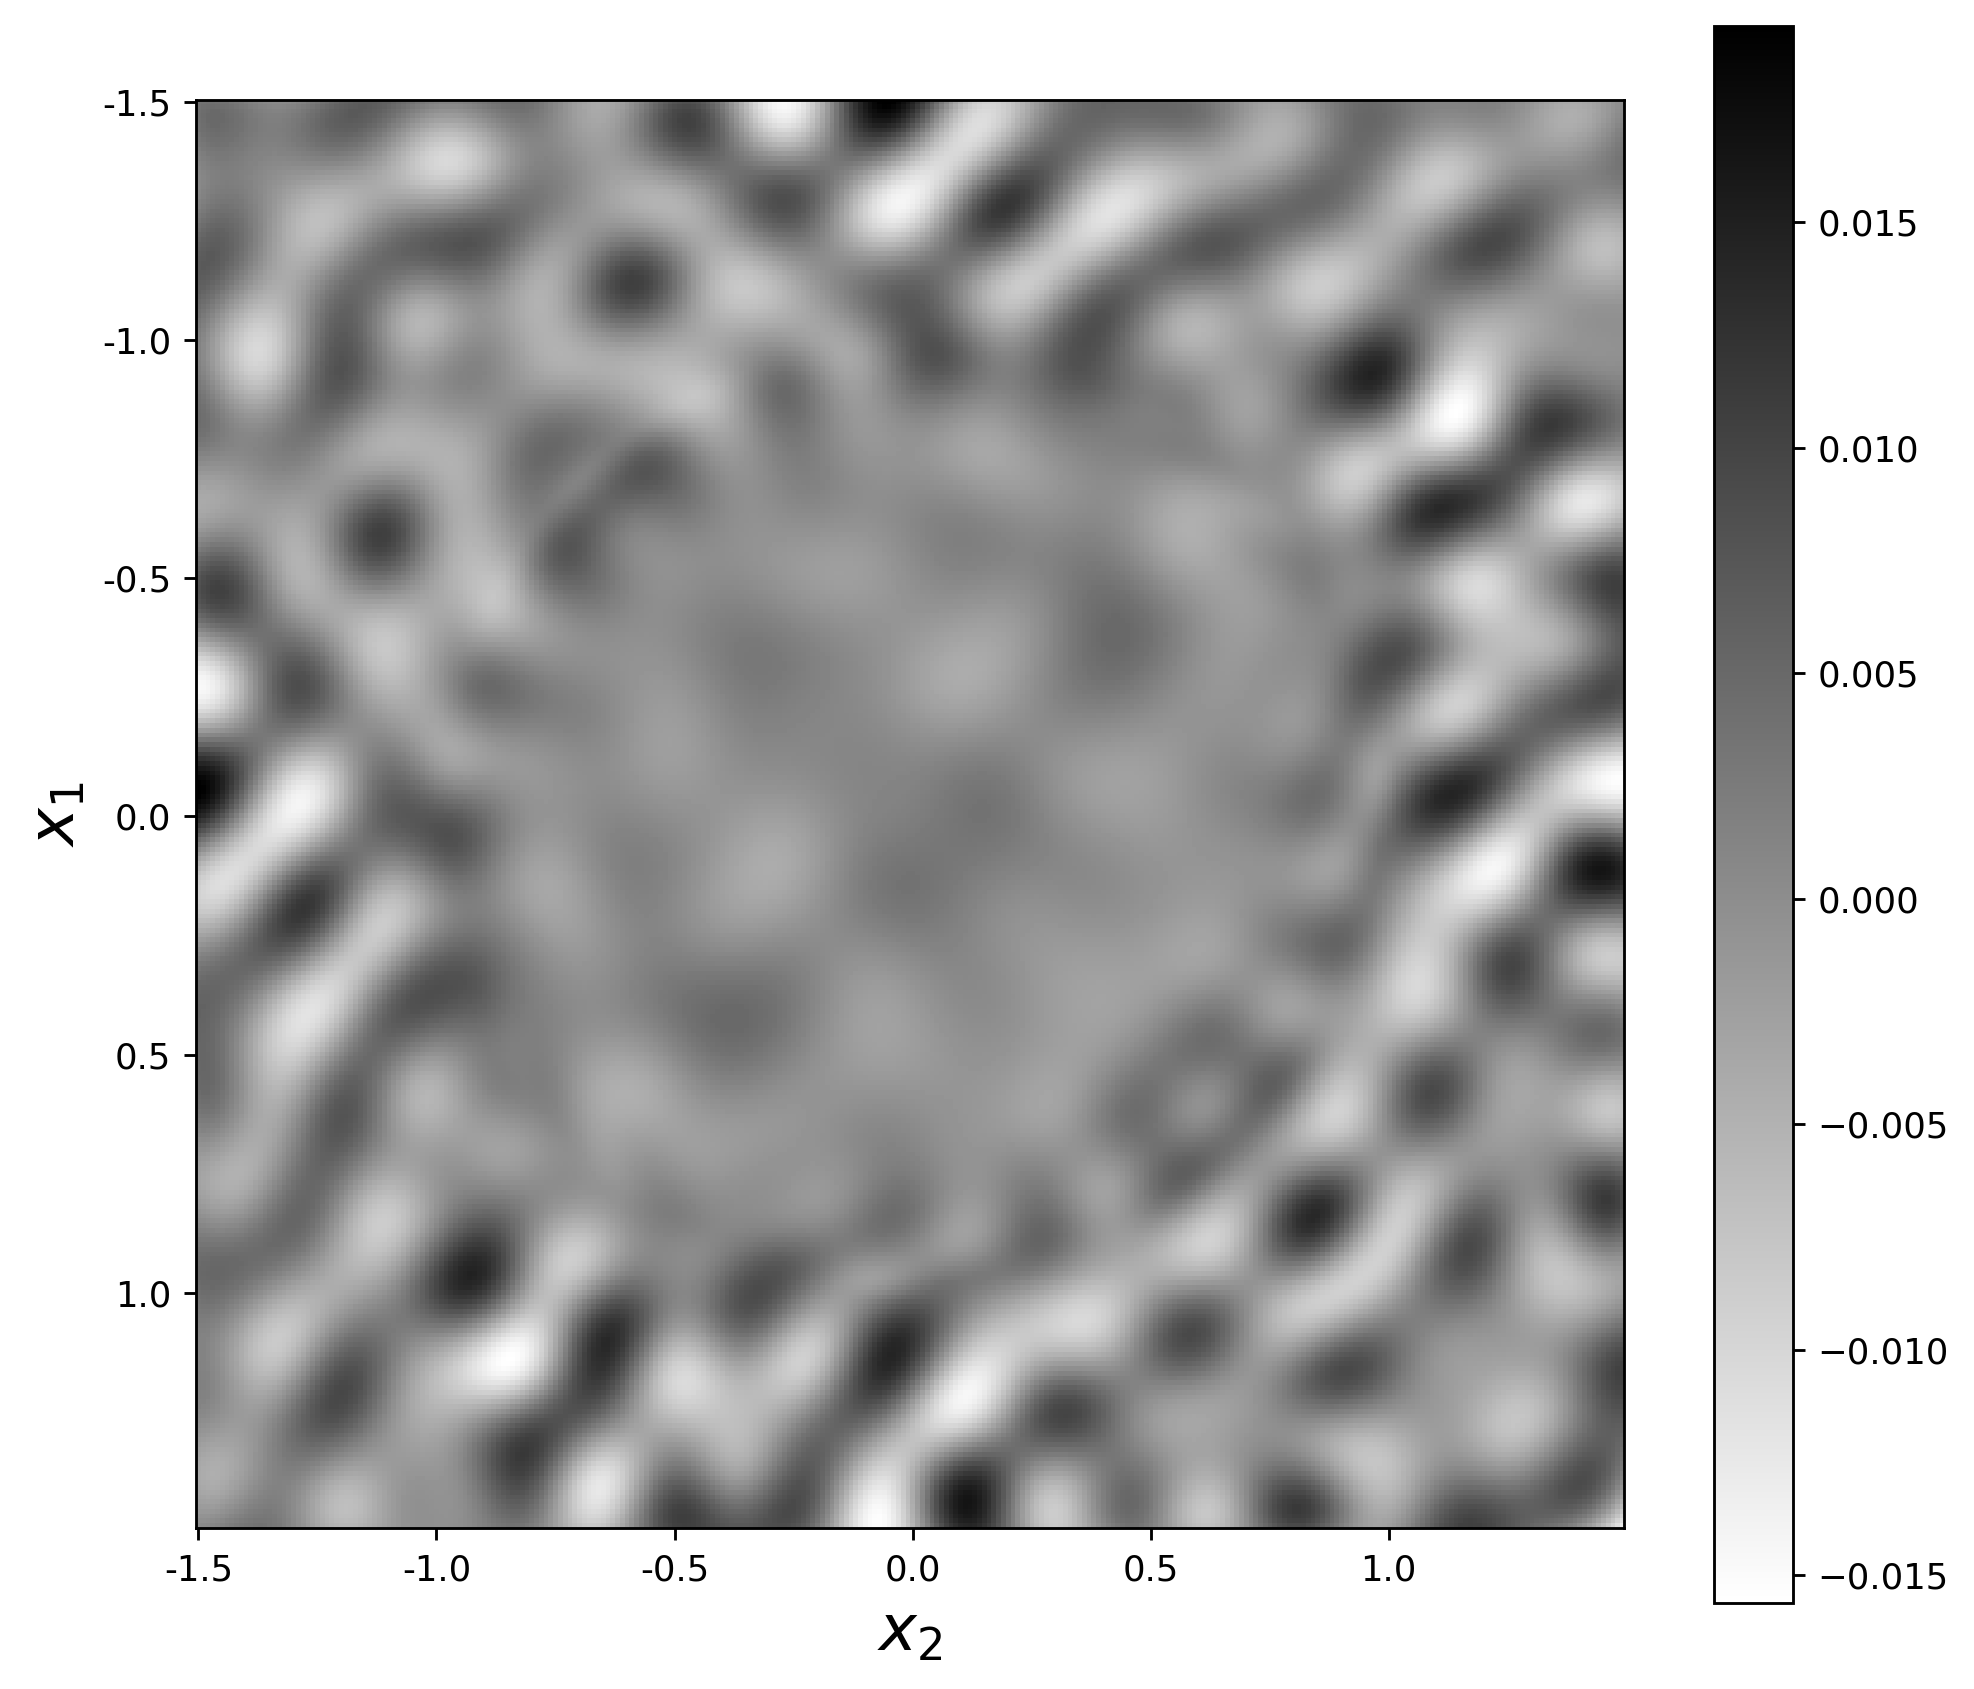

In [47]:
plt.figure(figsize=(9, 8), dpi=256)
plt.imshow(result_TS.real.reshape(to_reshape)[:, :, 149], cmap="binary")
plt.colorbar()
plt.xticks(np.arange(0, 300, 50), np.arange(-1.5, 1.5, 0.5))
plt.yticks(np.arange(0, 300, 50), np.arange(-1.5, 1.5, 0.5))
plt.ylabel(r"$x_1$", fontsize=18)
plt.xlabel(r"$x_2$", fontsize=18)

plt.figure(figsize=(9, 8), dpi=256)
plt.imshow(result_BICGStab.real.reshape(to_reshape)[:, :, 149], cmap="binary")
plt.colorbar()
plt.xticks(np.arange(0, 300, 50), np.arange(-1.5, 1.5, 0.5))
plt.yticks(np.arange(0, 300, 50), np.arange(-1.5, 1.5, 0.5))
plt.ylabel(r"$x_1$", fontsize=18)
plt.xlabel(r"$x_2$", fontsize=18)

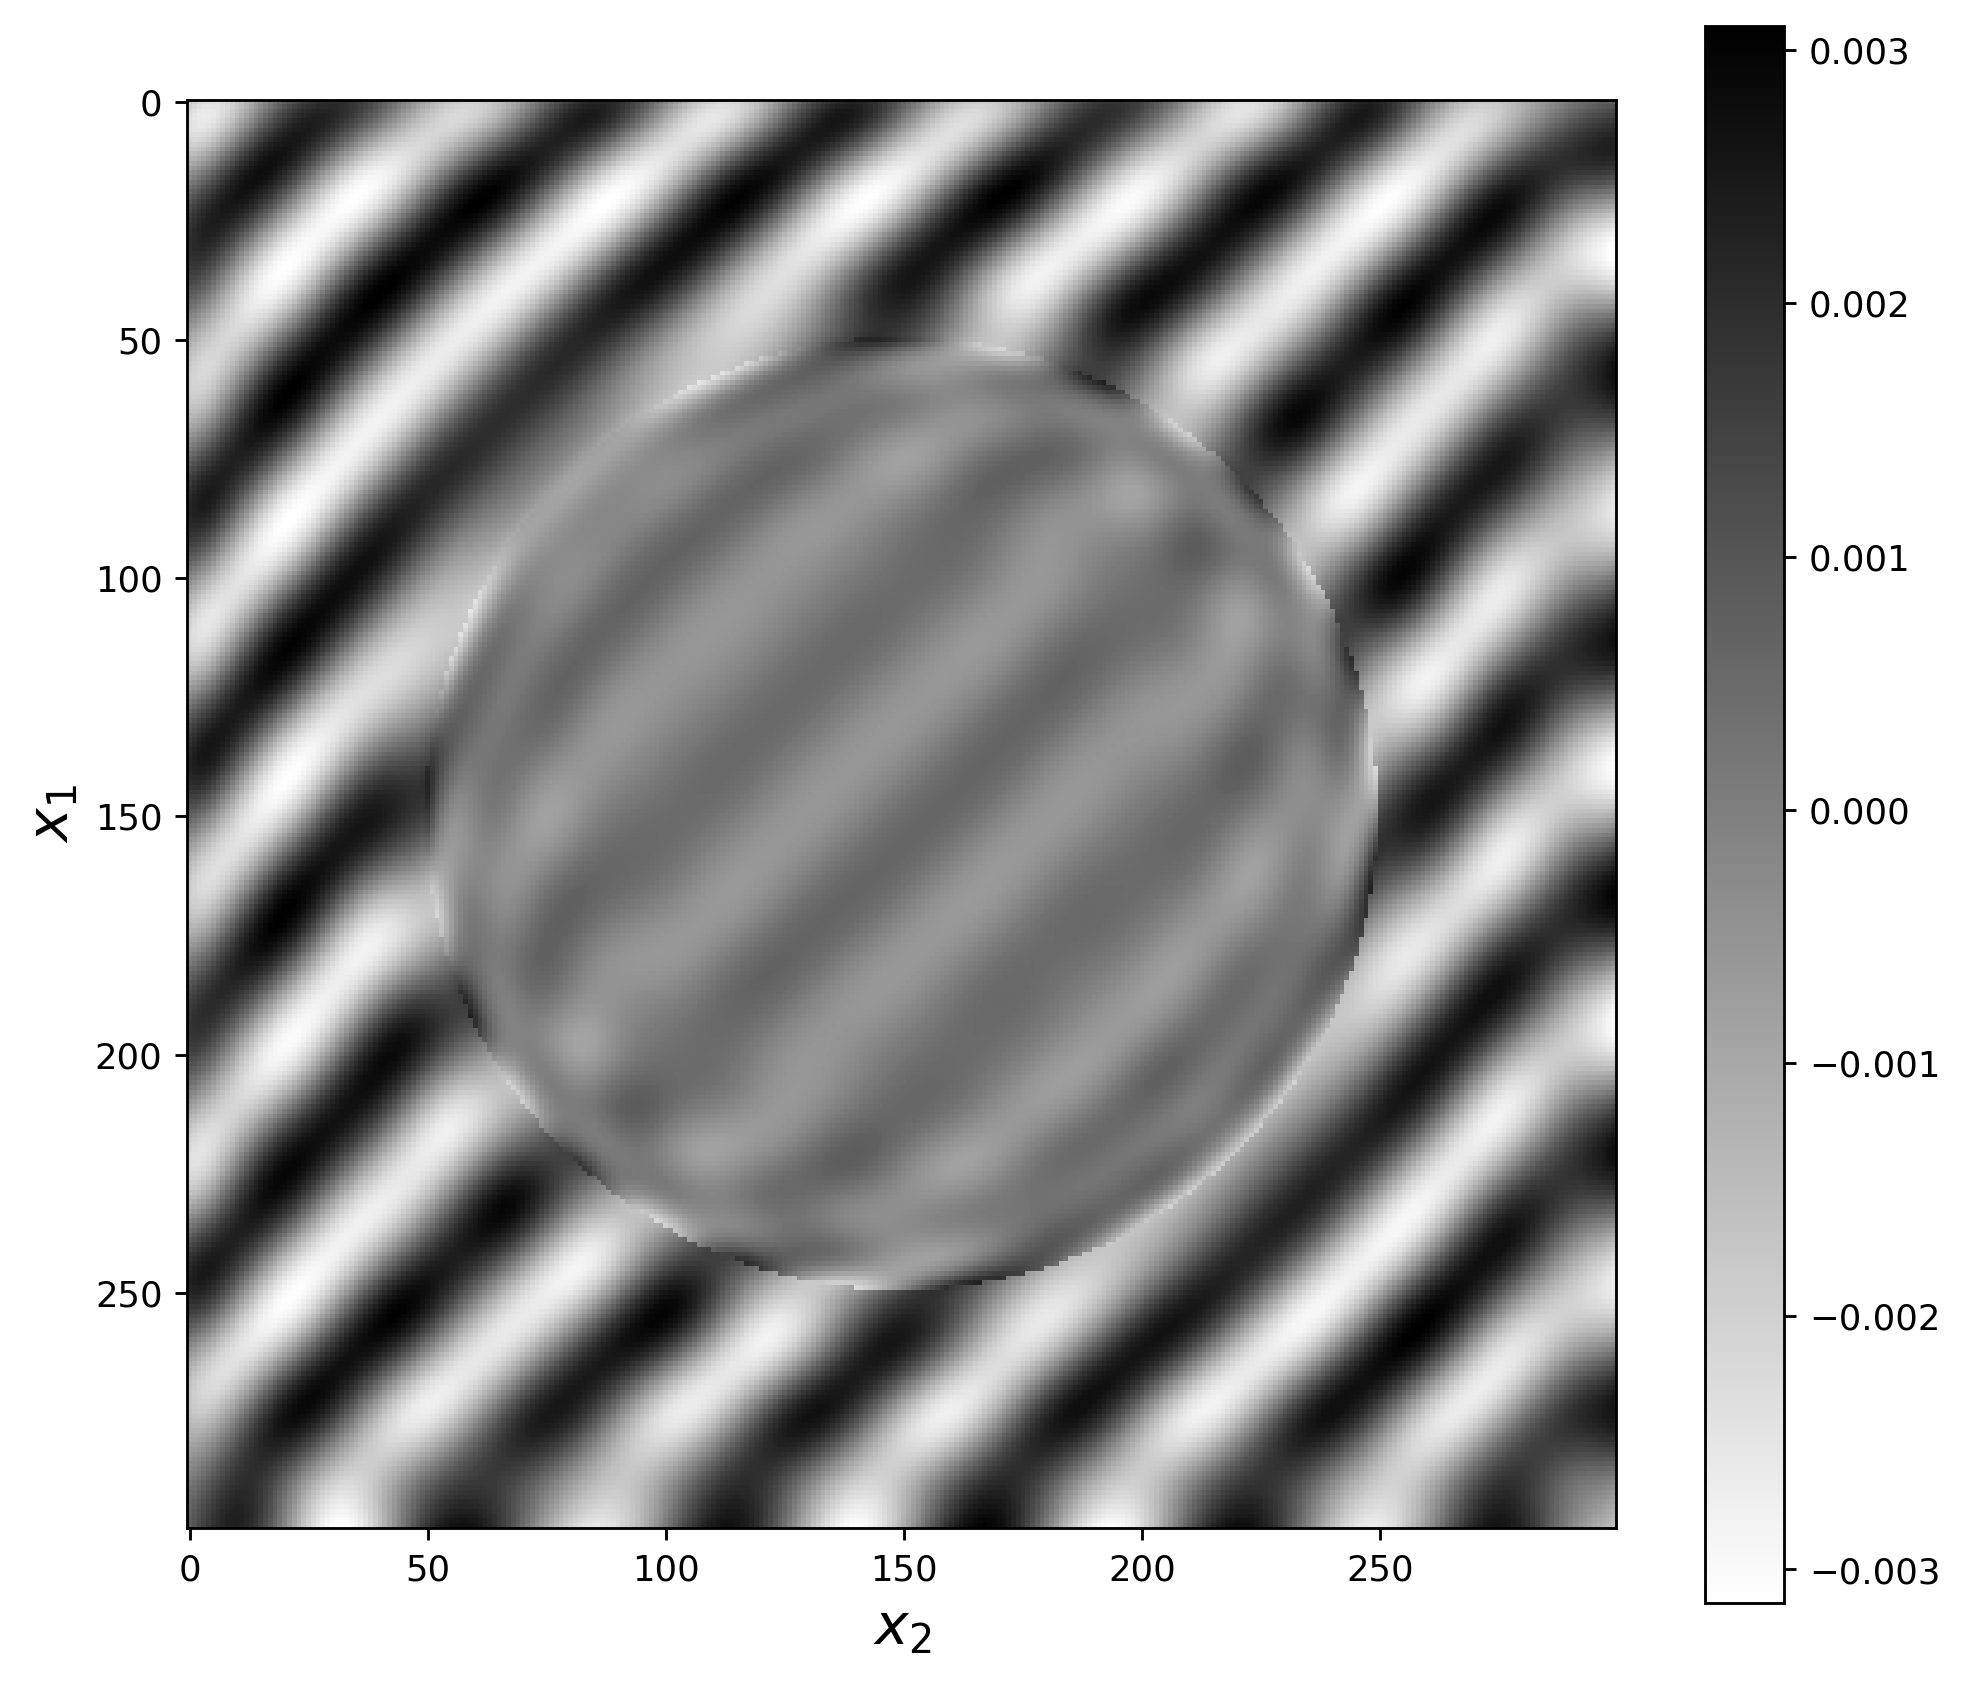

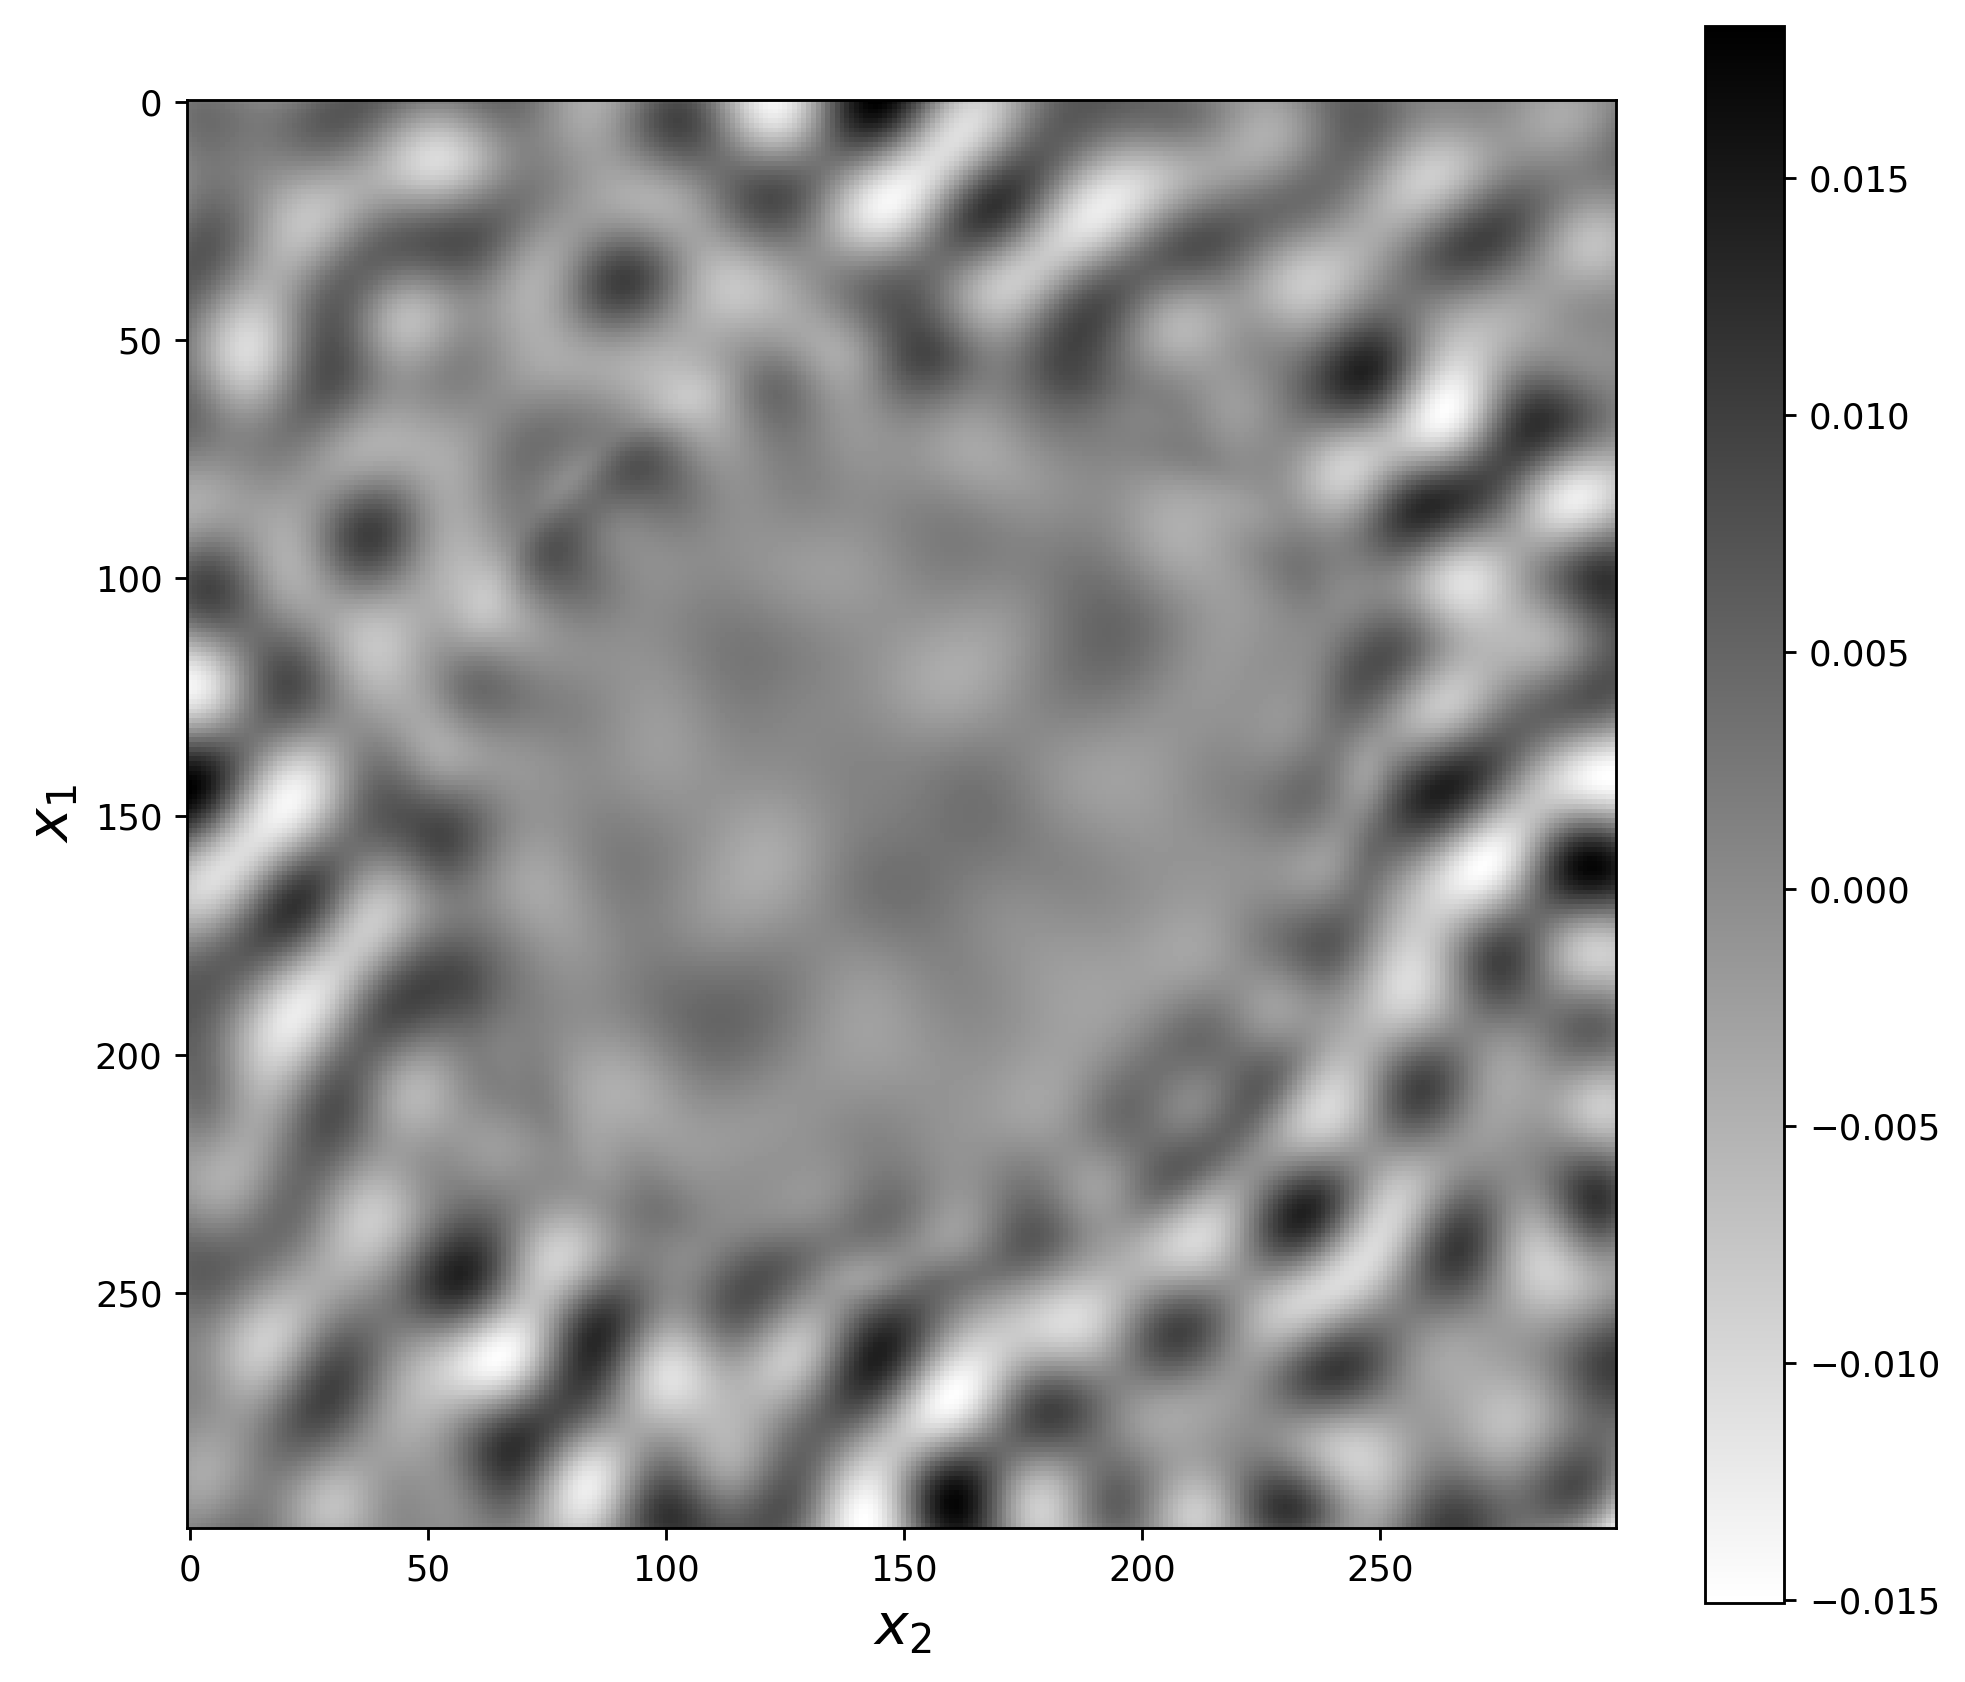

In [39]:
plot_yx(result_TS.reshape(to_reshape).real, grid.reshape(to_reshape + [3]))
plot_yx(result_BICGStab.reshape(to_reshape).real, grid.reshape(to_reshape + [3]))


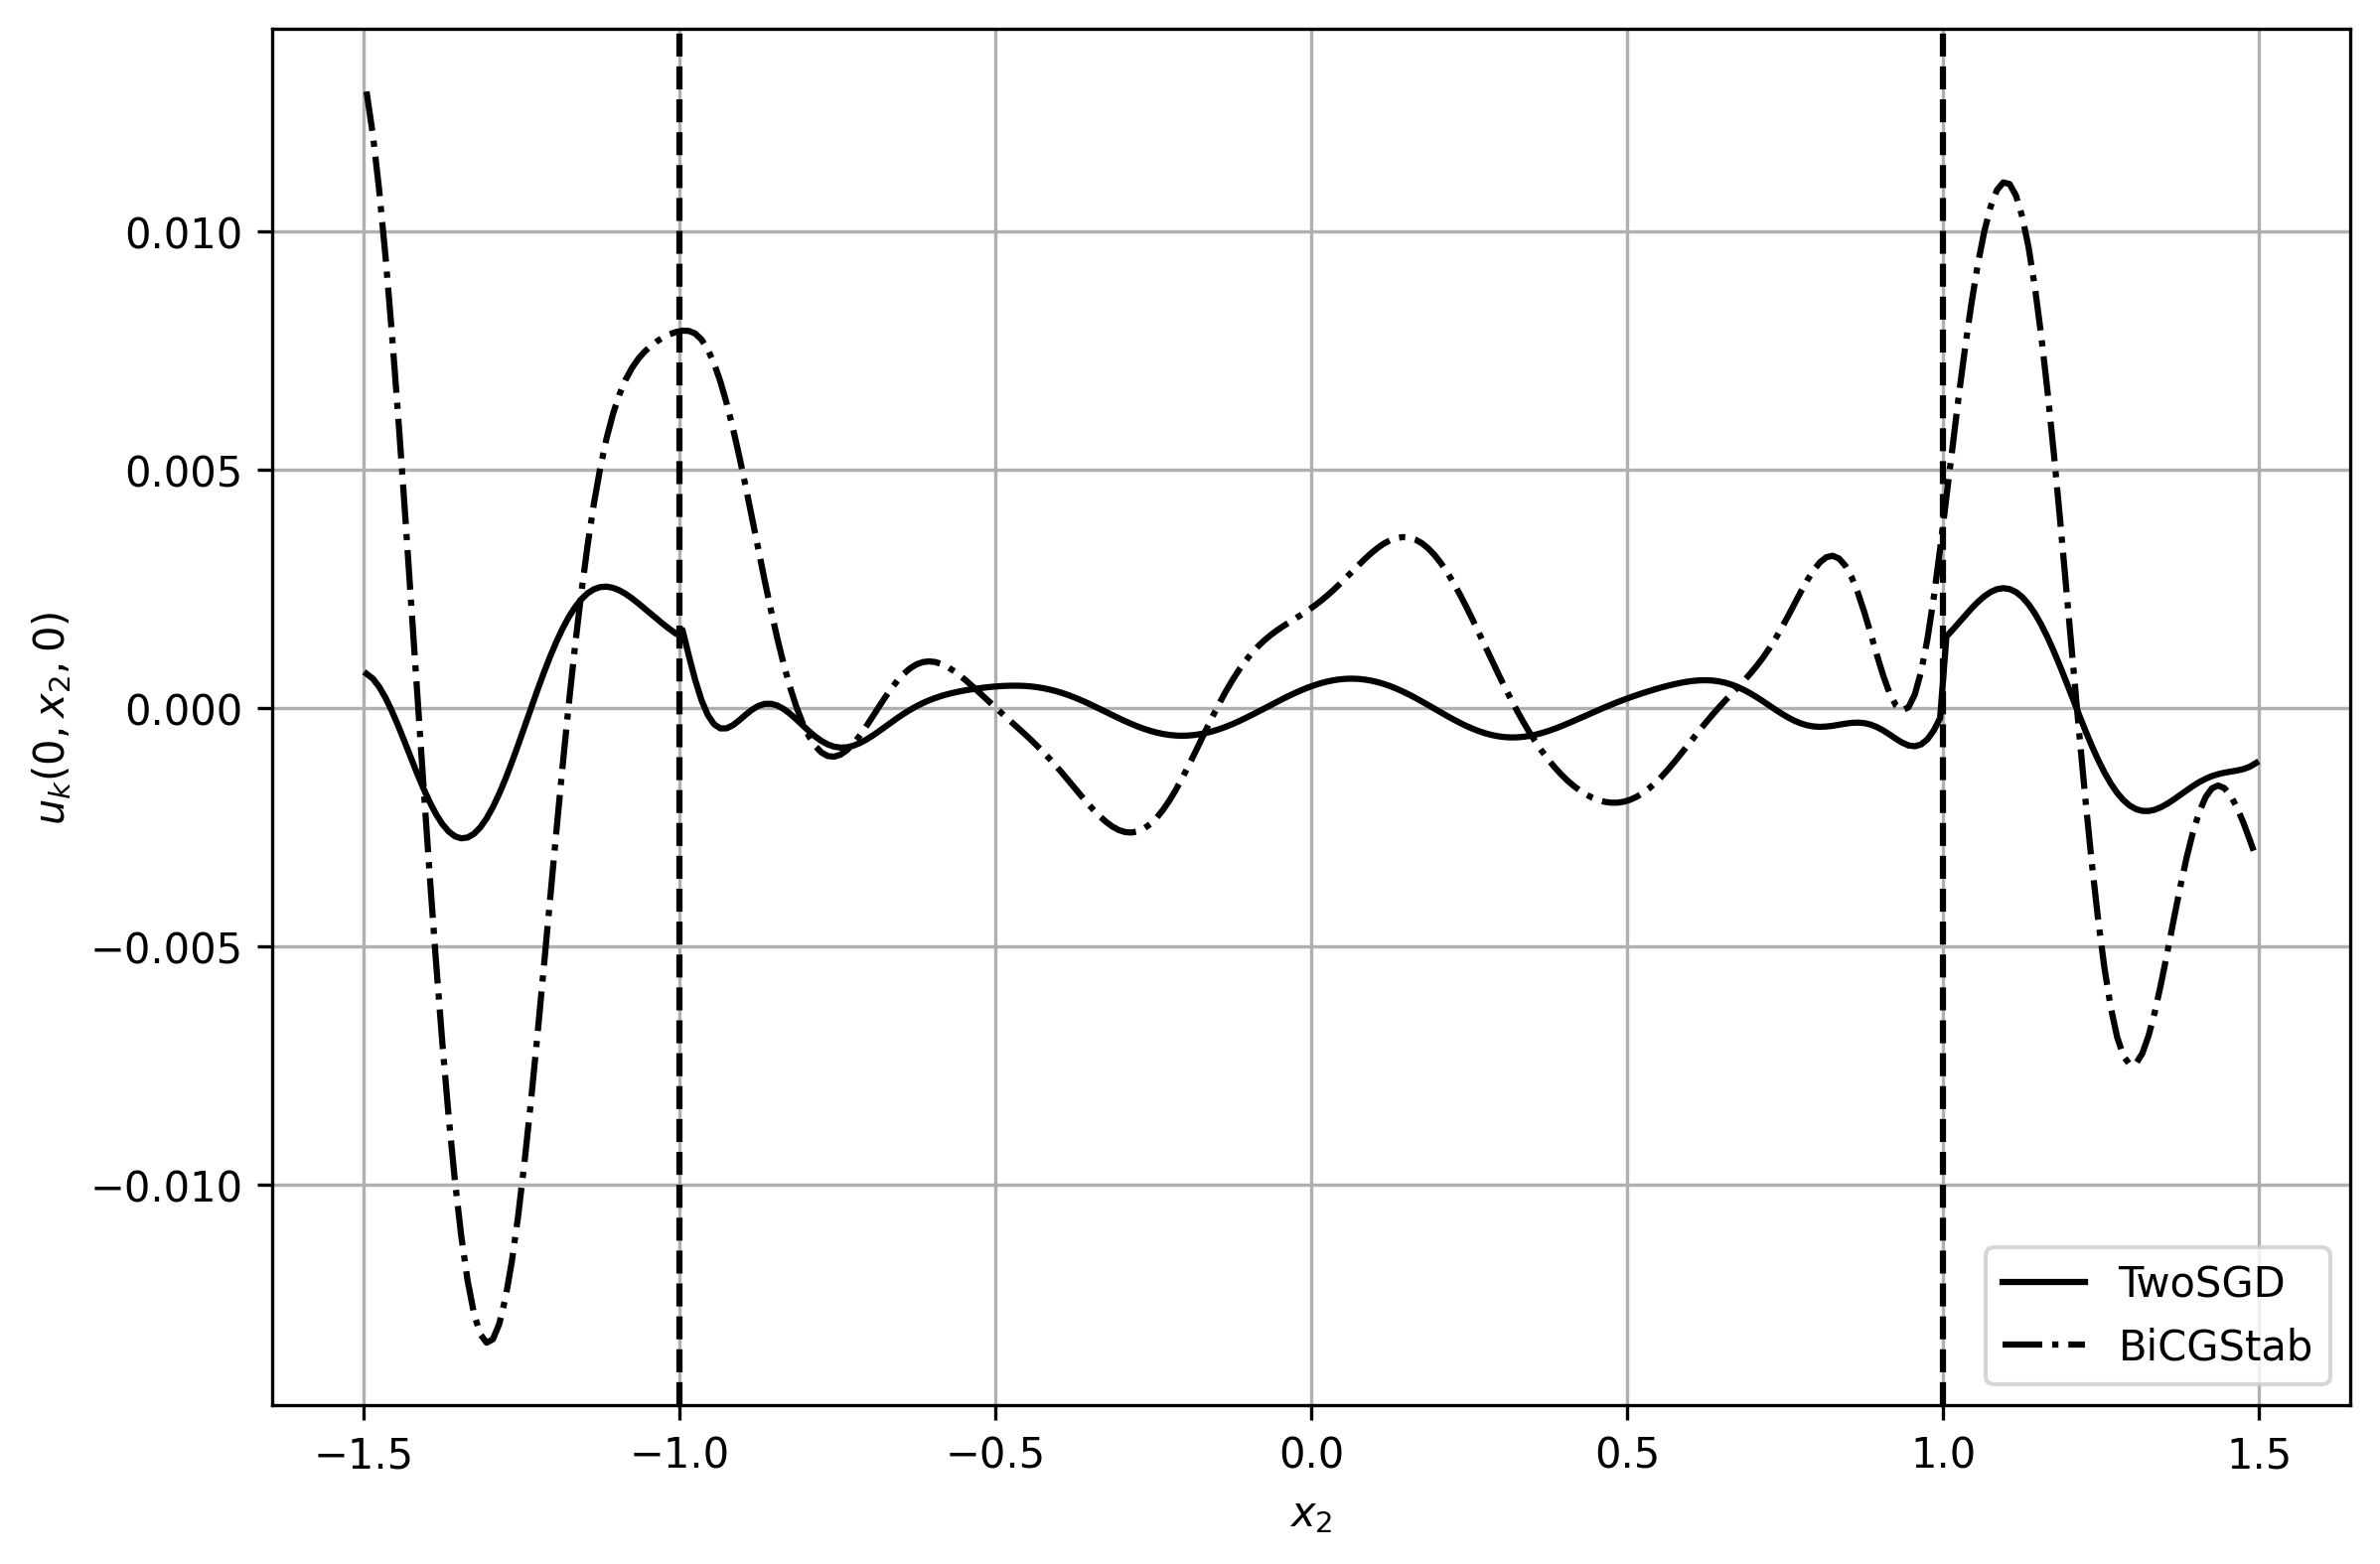

In [48]:
x_2 = grid.reshape(n_3, n_2, n_1, 3)[n_3//2, :, n_1//2, 1]

plt.figure(figsize=(9, 6), dpi=300)
plt.plot(x_2, result_TS.reshape(n_3, n_2, n_1).real[n_3//2, :, n_1//2], label= "TwoSGD", linestyle="-", c="black")
plt.plot(x_2, result_BICGStab.reshape(n_3, n_2, n_1).real[n_3//2, :, n_1//2], label="BiCGStab", linestyle="-.", c ="black")
plt.xlabel(r'$x_2$')
plt.ylabel(r'$u_k(0, x_2, 0)$')
plt.axvline(-1, c="black", linestyle="--")
plt.axvline(1, c="black", linestyle="--")
plt.legend()
plt.grid()

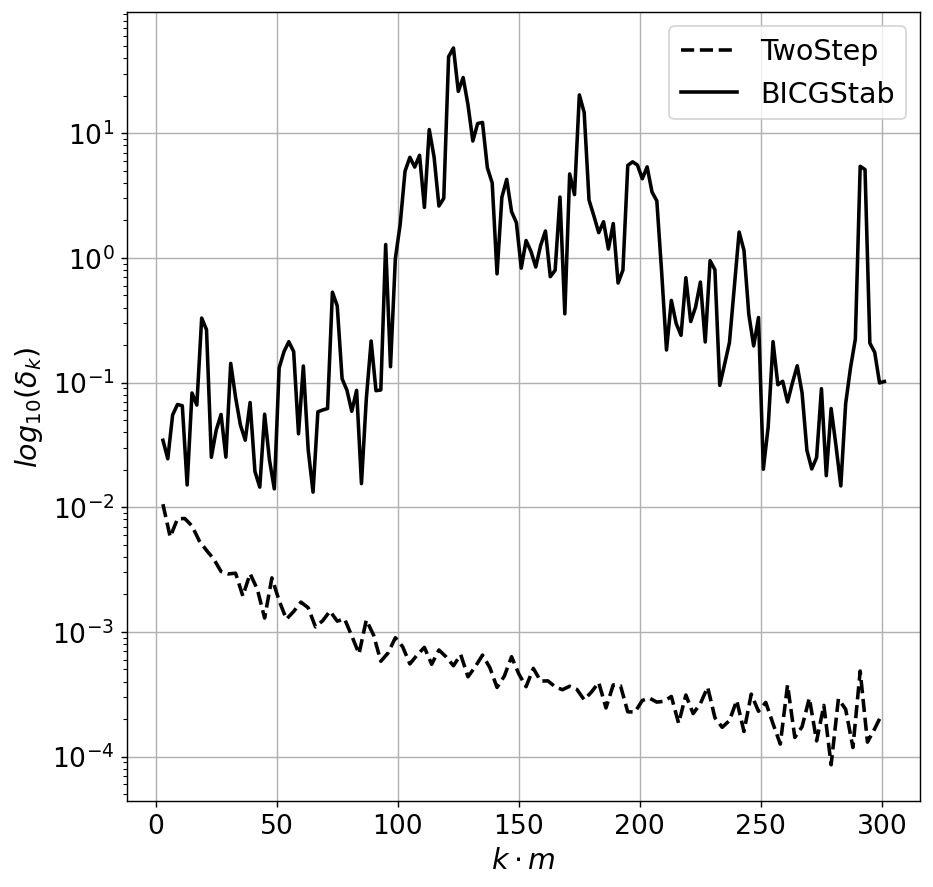

In [28]:
plt.figure(figsize=(8,8), dpi=128)
plt.plot(iters_TS,
         eps_TS, 
         label="TwoStep", 
         c="black", 
         linestyle="--", 
         linewidth=2)
plt.plot(iters_BICGStab[1:], 
         eps_BICGStab[1:], 
         label="BICGStab",
         c="black", 
         linestyle="-", 
         linewidth=2)
plt.yscale('log')
plt.legend(fontsize = 16)
plt.ylabel(r'$log_{10}(\delta_k)$', fontsize=16)
plt.xlabel(r'$k\cdot m$', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.show()

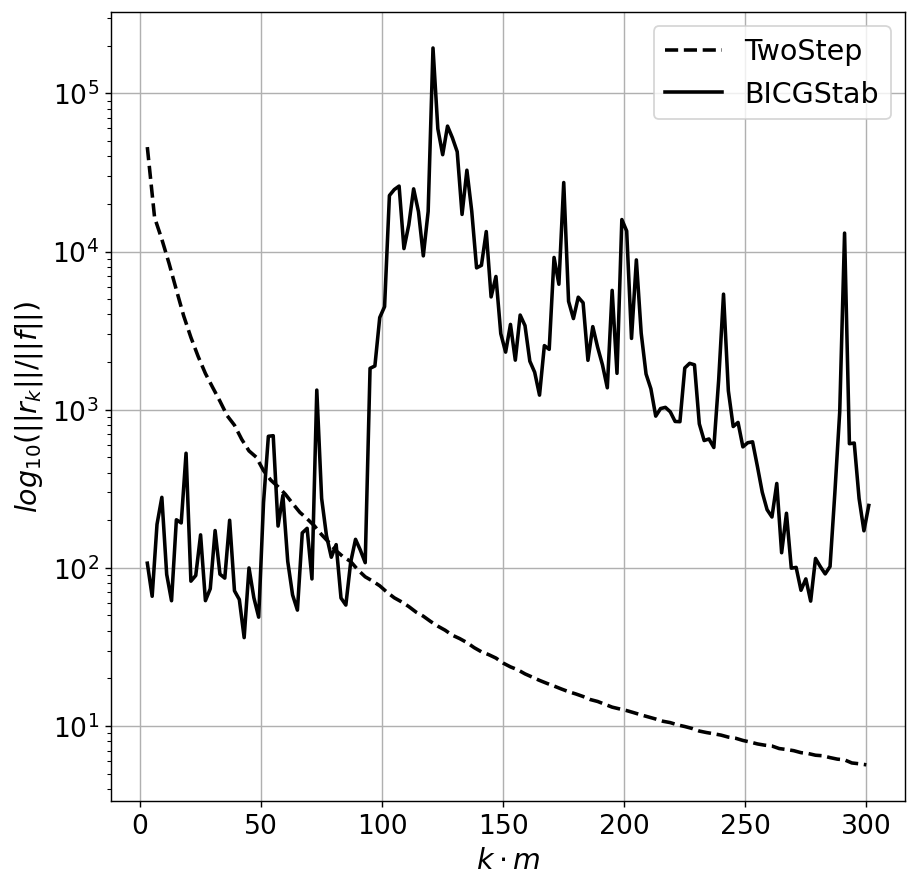

In [29]:
plt.figure(figsize=(8,8), dpi=128)
plt.plot(iters_TS,
         resid_TS, 
         label="TwoStep", 
         c="black", 
         linestyle="--", 
         linewidth=2)
plt.plot(iters_BICGStab[1:], 
         resid_BICGStab[1:], 
         label="BICGStab",
         c="black", 
         linestyle="-", 
         linewidth=2)
plt.yscale('log')
plt.legend(fontsize = 16)
plt.ylabel(r'$log_{10}(||r_k||/||f||)$', fontsize=16)
plt.xlabel(r'$k\cdot m$', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.show()

In [30]:
def plot_cube_scatter3d(vector_U, cubes_collocations,
                        figsize_opt=(14, 12),
                        cmap_opt="seismic",
                        marker_size_opt=150,
                        alpha_opt=0.75,
                        title_opt="k = 1, N = 10, L = 1",
                        xlabel_opt="X axis",
                        ylabel_opt="Y axis",
                        filename_opt="painting_scalar.png"):
    fig = plt.figure(figsize=figsize_opt, dpi = 256)
    ax = plt.axes(projection="3d")
    color_map = plt.get_cmap(cmap_opt)
    scatter_plot = ax.scatter3D(cubes_collocations[:, 0],
                                cubes_collocations[:, 1],
                                cubes_collocations[:, 2],
                                c=vector_U,
                                cmap=color_map,
                                s=marker_size_opt,
                                alpha=alpha_opt)
    plt.colorbar(scatter_plot)
    plt.xlabel(xlabel_opt, fontsize=16, labelpad=10)
    plt.ylabel(ylabel_opt, fontsize=16, labelpad=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title_opt)
    plt.tight_layout()
    plt.savefig(filename_opt)
    plt.show()

In [31]:
plot_cube_scatter3d(vector_U = result_TS.real, cubes_collocations=grid,
                        figsize_opt=(14, 12),
                        cmap_opt="gray",
                        marker_size_opt=70,
                        alpha_opt=0.75,
                        title_opt="",
                        xlabel_opt=r"$X_2$",
                        ylabel_opt=r"$X_1$",
                        filename_opt="painting_scalar.png")

C:\Users\user\AppData\Local\Temp\ipykernel_4588\3755245352.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


KeyboardInterrupt: 